In [8]:
import numpy as np
import os
import skimage.io as skio
from skimage import io
import matplotlib.pyplot as plt
import pandas as pd
indir = "G:/.shortcut-targets-by-id/1w3kIfvkBH_Xa1G856qbgk-8u0IRdcwZ3/MUSA 650 Final Project"

In [16]:
from tqdm import tqdm

import cv2
import os

deep_globe_path = os.path.join(indir, "deep_globe_imgs")

In [42]:
def load_images_from_dir(dir_path):
    images = []
    for filename in tqdm(os.listdir(dir_path), desc="Loading images"):
        img_path = os.path.join(dir_path, filename)
        img = cv2.imread(img_path)
        if img is None:
            print('Wrong path:', img_path)
            images.append(None)
        else:
            img = cv2.resize(img, dsize=(256, 256))
            images.append(img)
    images = [img for img in images if img is not None]
    return np.array(images)

train_dir = os.path.join(deep_globe_path, "train")
train_images = load_images_from_dir(train_dir)

Loading images: 100%|██████████| 1607/1607 [03:21<00:00,  7.99it/s]


Wrong path: G:/.shortcut-targets-by-id/1w3kIfvkBH_Xa1G856qbgk-8u0IRdcwZ3/MUSA 650 Final Project\deep_globe_imgs\train\desktop.ini


In [43]:
train_images.shape

(1606, 256, 256, 3)

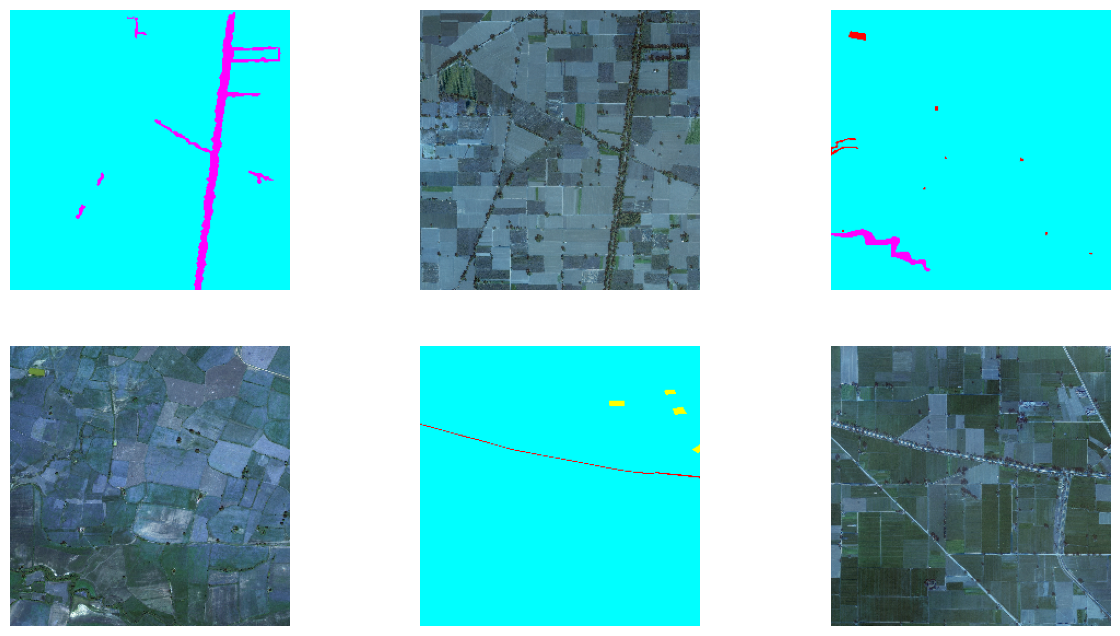

In [47]:
# print the first 6 images in a 2x3 grid
fig, ax = plt.subplots(2, 3, figsize=(15, 8))
for i in range(6):
    ax[i//3, i%3].imshow(train_images[i])
    ax[i//3, i%3].axis("off")
plt.show()

In [48]:
# split train_images into sat images and masks
sat_images = train_images[1::2]
mask_images = train_images[::2]

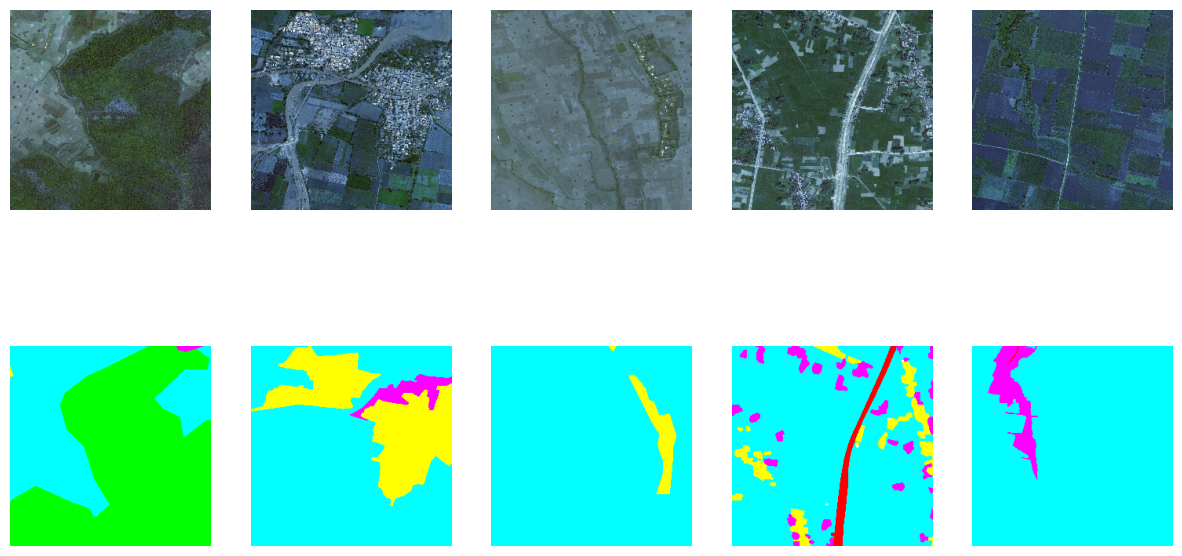

In [49]:
# plot five random images in sat_images along with their corresponding masks
fig, ax = plt.subplots(2, 5, figsize=(15, 8))
for i in range(5):
    idx = np.random.randint(len(sat_images))
    ax[0, i].imshow(sat_images[idx])
    ax[0, i].axis("off")
    ax[1, i].imshow(mask_images[idx])
    ax[1, i].axis("off")
plt.show()

In [50]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

# Define data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [51]:
# Apply data augmentation to satellite and mask images
sat_images_aug = []
mask_images_aug = []
for sat_image, mask_image in tqdm(zip(sat_images, mask_images), desc="Augmenting images"):
    # Apply the same augmentation to both the satellite and mask images
    sat_aug = datagen.random_transform(sat_image)
    mask_aug = datagen.random_transform(mask_image)
    sat_images_aug.append(sat_aug)
    mask_images_aug.append(mask_aug)

Augmenting images: 803it [00:06, 115.57it/s]


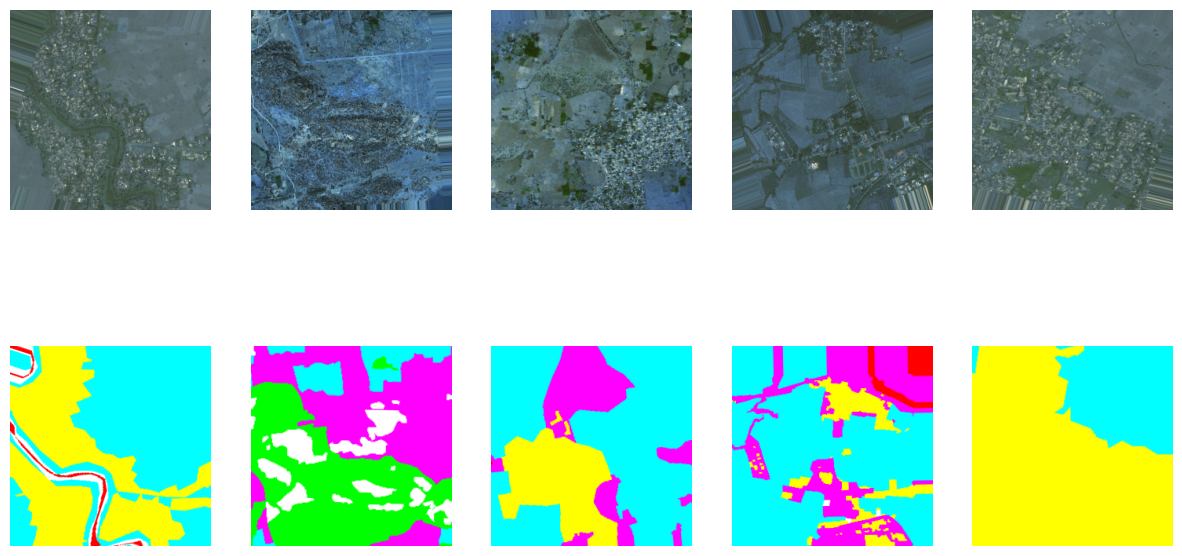

In [53]:
# plot five random images in sat_images along with their corresponding masks
fig, ax = plt.subplots(2, 5, figsize=(15, 8))
for i in range(5):
    idx = np.random.randint(len(sat_images))
    ax[0, i].imshow(sat_images_aug[idx])
    ax[0, i].axis("off")
    ax[1, i].imshow(mask_images_aug[idx])
    ax[1, i].axis("off")
plt.show()

In [54]:
# concatenate the original and augmented images
sat_images = np.concatenate((sat_images, sat_images_aug))
mask_images = np.concatenate((mask_images, mask_images_aug))

In [58]:
mask_images.shape

(1606, 256, 256, 3)

In [63]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sat_images, mask_images, test_size=0.2)

In [67]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1284, 256, 256, 3)
X_test shape: (322, 256, 256, 3)
y_train shape: (1284, 256, 256, 3)
y_test shape: (322, 256, 256, 3)


In [69]:
from keras.utils import to_categorical

# Assuming y_train and y_test are numpy arrays of shape (n, height, width)
class_rgb = {
    (0, 255, 255): 0,   # urban_land
    (255, 255, 0): 1,   # agriculture_land
    (255, 0, 255): 2,   # rangeland
    (0, 255, 0): 3,     # forest_land
    (0, 0, 255): 4,     # water
    (255, 255, 255): 5, # barren_land
    (0, 0, 0): 6        # unknown
}
num_classes = len(class_rgb)

# Convert y_train and y_test to integer labels
y_train_int = np.zeros(y_train.shape[:-1], dtype=np.int32)
y_test_int = np.zeros(y_test.shape[:-1], dtype=np.int32)
for rgb, label in class_rgb.items():
    y_train_int[(y_train == np.array(rgb)).all(axis=-1)] = label
    y_test_int[(y_test == np.array(rgb)).all(axis=-1)] = label

# Convert y_train and y_test to one-hot encoded categorical format
y_train = to_categorical(y_train_int, num_classes=num_classes)
y_test = to_categorical(y_test_int, num_classes=num_classes)

In [75]:
y_train.shape

(1284, 256, 256, 7)

In [76]:
y_test.shape

(322, 256, 256, 7)

In [79]:
# Define ResNet model
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Concatenate, Activation, Cropping2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define ResNet model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Add decoder layers
up1 = Conv2D(512, 3, padding='same', activation='relu')(base_model.output)
up1 = UpSampling2D(size=(2, 2))(up1)
up1 = Concatenate()([base_model.get_layer('conv4_block6_out').output, up1])
up1 = Conv2D(256, 3, padding='same', activation='relu')(up1)

up2 = Conv2D(256, 3, padding='same', activation='relu')(up1)
up2 = UpSampling2D(size=(2, 2))(up2)
up2 = Concatenate()([base_model.get_layer('conv3_block4_out').output, up2])
up2 = Conv2D(128, 3, padding='same', activation='relu')(up2)

up3 = Conv2D(128, 3, padding='same', activation='relu')(up2)
up3 = UpSampling2D(size=(2, 2))(up3)
up3 = Concatenate()([base_model.get_layer('conv2_block3_out').output, up3])
up3 = Conv2D(64, 3, padding='same', activation='relu')(up3)

up4 = Conv2D(64, 3, padding='same', activation='relu')(up3)
up4 = UpSampling2D(size=(2, 2))(up4)
up4 = Concatenate()([base_model.get_layer('conv1_relu').output, up4])
up4 = Conv2D(32, 3, padding='same', activation='relu')(up4)

# Output layer
output = Conv2D(num_classes, 1)(up4)
output = UpSampling2D(size=(2, 2))(output)
output = Cropping2D(cropping=((0, 0), (0, 0)))(output) # Crop to match input shape
output = Activation('softmax')(output)

# Compile model
model = Model(inputs=[base_model.input], outputs=[output])
model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Print summary
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [80]:
# Train model
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
41/41 [==============================] - 431s 10s/step - loss: 1.4603 - accuracy: 0.6151 - val_loss: 2.0094 - val_accuracy: 0.2738
Epoch 2/10
41/41 [==============================] - 398s 10s/step - loss: 0.8917 - accuracy: 0.7052 - val_loss: 1.3627 - val_accuracy: 0.4462
Epoch 3/10
41/41 [==============================] - 382s 9s/step - loss: 0.8235 - accuracy: 0.7311 - val_loss: 1.1968 - val_accuracy: 0.6705
Epoch 4/10
41/41 [==============================] - 381s 9s/step - loss: 0.7369 - accuracy: 0.7628 - val_loss: 0.8239 - val_accuracy: 0.7204
Epoch 5/10
41/41 [==============================] - 389s 10s/step - loss: 0.7090 - accuracy: 0.7710 - val_loss: 0.9051 - val_accuracy: 0.7129
Epoch 6/10
41/41 [==============================] - 414s 10s/step - loss: 0.7372 - accuracy: 0.7589 - val_loss: 0.9870 - val_accuracy: 0.5648
Epoch 7/10
41/41 [==============================] - 435s 11s/step - loss: 0.6704 - accuracy: 0.7809 - val_loss: 0.8616 - val_accuracy: 0.7402
Epoch 8/

In [81]:
model_path = os.path.join(indir, "deepglobe_256_sq_resnet50_v1.h5")

model.save(model_path)

In [82]:
from tensorflow.keras.models import load_model

# Load saved model
loaded_model = load_model(model_path)

Now, load my data and predict based on it.

In [83]:
indir = "G:/.shortcut-targets-by-id/1w3kIfvkBH_Xa1G856qbgk-8u0IRdcwZ3/MUSA 650 Final Project"

# set the filepath
patches_path = os.path.join(indir, "patches")

In [84]:
# read in "patches_0.npy"
patches_sample = np.load(os.path.join(patches_path, "patches_0.npy"))

In [85]:
# Calculate the percentage of 255-valued pixels in each image
drop_pixels = (patches_sample == 255).sum(axis=(1, 2, 3))
total_pixels = patches_sample.shape[1] * patches_sample.shape[2] * patches_sample.shape[3]
drop_percentages = drop_pixels / total_pixels

# Set the threshold for filtering images
threshold = 0.05

# Find indices of images with less than 5% 255-valued pixels
valid_indices = np.where(drop_percentages < threshold)[0]

# Filter the array based on valid_indices
filtered_patches = patches_sample[valid_indices]

print("Original array shape:", patches_sample.shape)
print("Filtered array shape:", filtered_patches.shape)

Original array shape: (520, 256, 256, 3)
Filtered array shape: (191, 256, 256, 3)


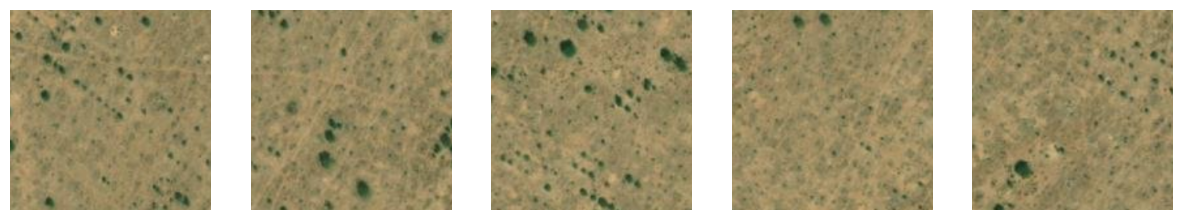

In [86]:
# plot the first 5 patches
fig, ax = plt.subplots(1, 5, figsize=(15, 15))
for i in range(5):
    ax[i].imshow(filtered_patches[i])
    ax[i].axis("off")
plt.show()

In [87]:
# Predict pixel labels for input images
predicted_masks = loaded_model.predict(filtered_patches)

# Convert predicted masks to integer format
predicted_masks = np.argmax(predicted_masks, axis=-1)

6/6 [==============================] - 11s 2s/step


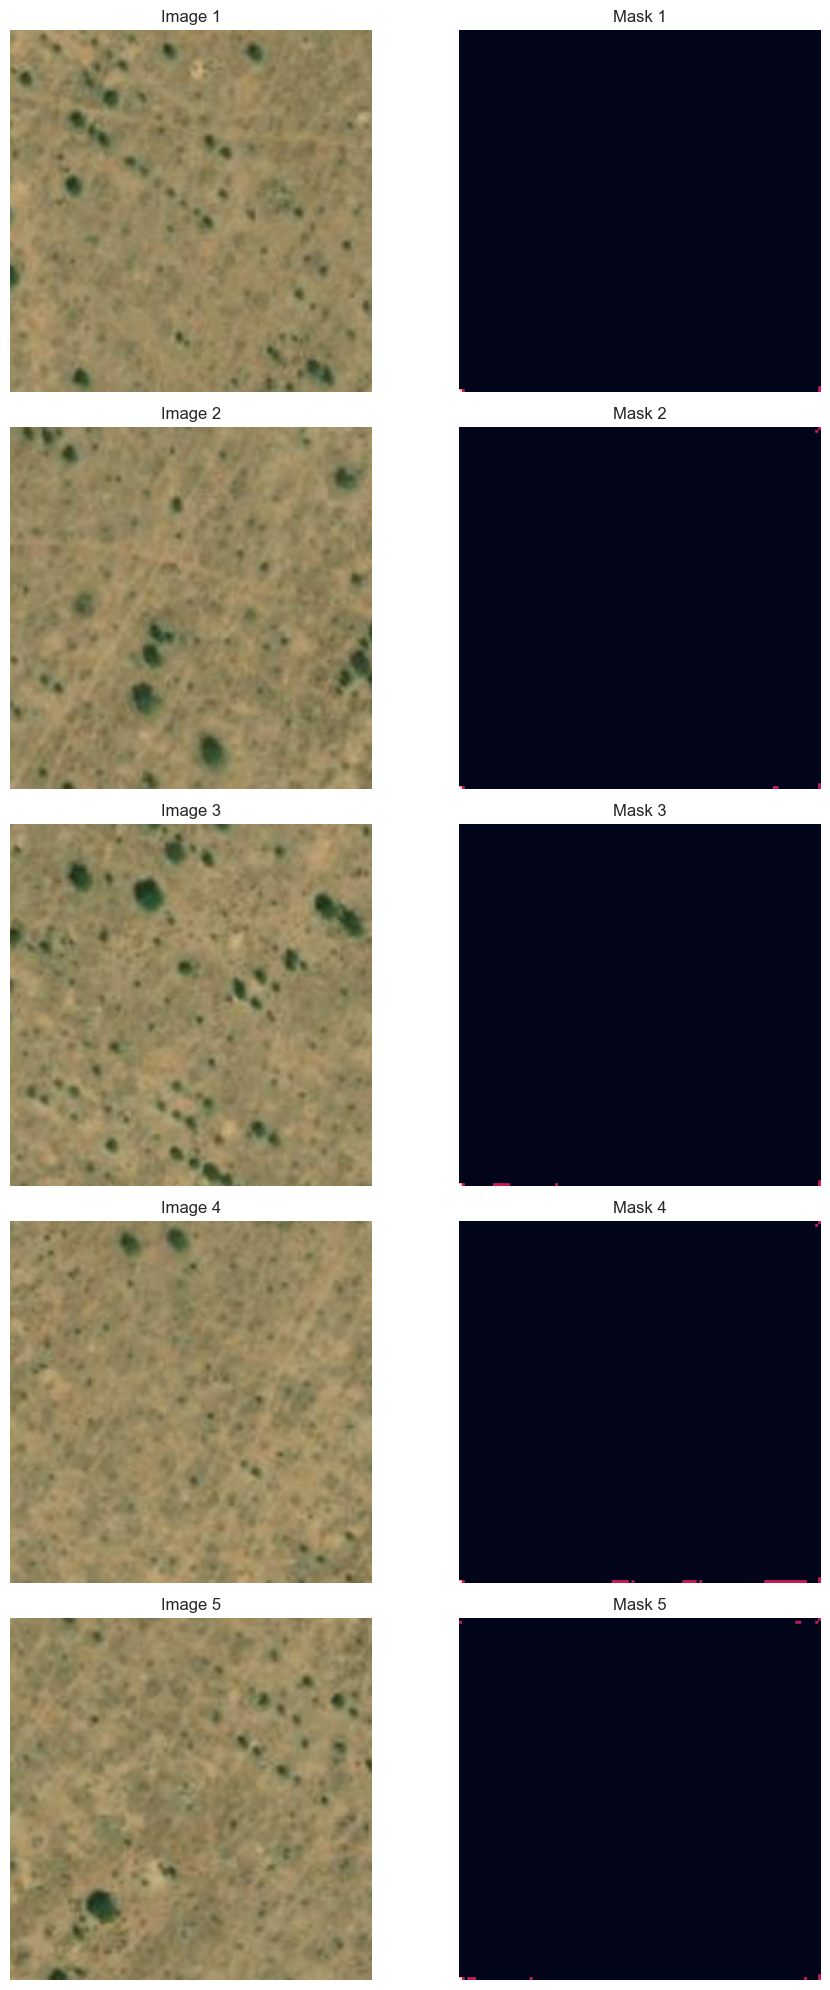

In [92]:
# Display first five original images and masks
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))

for i in range(5):
    # Display original image
    ax = axs[i, 0]
    ax.imshow(filtered_patches[i])
    ax.set_axis_off()
    ax.set_title('Image {}'.format(i + 1))

    # Display mask
    ax = axs[i, 1]
    ax.imshow(predicted_masks[i])
    ax.set_axis_off()
    ax.set_title('Mask {}'.format(i + 1))

plt.tight_layout()
plt.show()

## Scrap from here down

In [14]:
zip_path = os.path.join(indir, "deep_globe.zip")

extract_path = os.path.join(indir, "deep_globe_imgs")

# Extract contents of zip file
with ZipFile(zip_path, 'r') as zipObj:
   # Extract all the contents of zip file to a new folder
   zipObj.extractall(extract_path)

BadZipFile: File is not a zip file

In [ ]:

# set the filepath
patches_path = os.path.join(indir, "patches")

In [ ]:
# read in "patches_0.npy"
patches_sample = np.load(os.path.join(patches_path, "patches_0.npy"))

In [ ]:
# Calculate the percentage of 255-valued pixels in each image
drop_pixels = (patches_sample == 255).sum(axis=(1, 2, 3))
total_pixels = patches_sample.shape[1] * patches_sample.shape[2] * patches_sample.shape[3]
drop_percentages = drop_pixels / total_pixels

# Set the threshold for filtering images
threshold = 0.05

# Find indices of images with less than 5% 255-valued pixels
valid_indices = np.where(drop_percentages < threshold)[0]

# Filter the array based on valid_indices
filtered_patches = patches_sample[valid_indices]

print("Original array shape:", patches_sample.shape)
print("Filtered array shape:", filtered_patches.shape)

In [ ]:
# plot the first 5 patches
fig, ax = plt.subplots(1, 5, figsize=(15, 15))
for i in range(5):
    ax[i].imshow(filtered_patches[i])
    ax[i].axis("off")
plt.show()

## First attempt with torch geo

In [ ]:
from pytorch_lightning import Trainer
from torchgeo.datamodules import BigEarthNetDataModule
from torchgeo.trainers import SemanticSegmentationTask

In [ ]:
datamodule = BigEarthNetDataModule(root_dir="...", batch_size=64, num_workers=6)

In [ ]:
task = SemanticSegmentationTask(segmentation_model="unet", encoder_weights="imagenet", learning_rate=0.1)

In [ ]:
trainer = Trainer(gpus=1, default_root_dir="...")

In [ ]:
trainer.fit(model=task, datamodule=datamodule)

In [ ]:
results = trainer.test(model=task, datamodule=datamodule)

print(results)

In [ ]:
for sample in datamodule:
    image = sample["image"]
    target = sample["mask"]

In [ ]:
datamodule.image

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning import Trainer
from torchgeo.datamodules import DeepGlobeLandCoverDataModule
from torchgeo.trainers import SemanticSegmentationTask

class CustomRGBDataset(Dataset):
    def __init__(self, filtered_patches, transform=None):
        self.filtered_patches = filtered_patches
        self.transform = transform

    def __len__(self):
        return len(self.filtered_patches)

    def __getitem__(self, idx):
        image = self.filtered_patches[idx]

        if self.transform:
            image = self.transform(image)

        return image

In [ ]:
test_dataset = CustomRGBDataset(filtered_patches)
test_dataloader = DataLoader(test_dataset, batch_size=64, num_workers=6)

datamodule = DeepGlobeLandCoverDataModule(
    root_dir="...",
    batch_size=64,
    num_workers=6
)

In [ ]:
task = SemanticSegmentationTask(
    model="unet",
    encoder_weights="imagenet",
    learning_rate=0.1,
    ignore_index=None
)

In [ ]:

trainer = Trainer(gpus=1, default_root_dir="...")

trainer.fit(model=task, datamodule=datamodule)

# Test the model on your custom dataset
results = trainer.test(model=task, test_dataloaders=test_dataloader)

print(results)

In [ ]:
import os
import torch

model_path = os.path.join(indir, "bigearthnet19_pretrained_imagenet1K_swin.pth.tar")

model = torch.jit.load(model_path)

## Second attempt via kaggle notebook

https://www.kaggle.com/code/balraj98/deepglobe-land-cover-classification-deeplabv3

In [ ]:
!pipenv update

In [ ]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

In [ ]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

In [ ]:
DATA_DIR = '../input/deepglobe-land-cover-classification-dataset'

metadata_df = pd.read_csv(os.path.join(DATA_DIR, 'metadata.csv'))
metadata_df = metadata_df[metadata_df['split']=='train']
metadata_df = metadata_df[['image_id', 'sat_image_path', 'mask_path']]
metadata_df['sat_image_path'] = metadata_df['sat_image_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
metadata_df['mask_path'] = metadata_df['mask_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
# Shuffle DataFrame
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)

# Perform 90/10 split for train / val
valid_df = metadata_df.sample(frac=0.1, random_state=42)
train_df = metadata_df.drop(valid_df.index)
len(train_df), len(valid_df)

In [ ]:


class_dict = pd.read_csv(os.path.join(DATA_DIR, 'class_dict.csv'))
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)



## From chatgpt

In [1]:
import torch
import torchvision
import numpy as np
import cv2

In [2]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Define the DeepGlobe Land Cover dataset
class DeepGlobeDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, transform=None):
        self.dataset_path = dataset_path
        self.transform = transform

        # Load the dataset
        self.images = np.load(dataset_path + 'images.npy')
        self.labels = np.load(dataset_path + 'labels.npy')

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]

        # Apply the transforms, if any
        if self.transform:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)

In [4]:
# Define the model architecture
class SegmentationModel(torch.nn.Module):
    def __init__(self, num_classes=6):
        super(SegmentationModel, self).__init__()

        self.backbone = torchvision.models.resnet50(pretrained=True)
        self.conv1 = torch.nn.Conv2d(2048, 512, kernel_size=3, stride=1, padding=1)
        self.relu1 = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(512, num_classes, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)

        return x

In [5]:
# Define the training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)

    return epoch_loss

In [6]:
# Define the validation function
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for i, data in enumerate(val_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

    epoch_loss = running_loss / len(val_loader)

    return epoch_loss

In [7]:
# Set up the dataloader for the DeepGlobe Land Cover dataset
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = DeepGlobeDataset('path/to/train/dataset/', transform=train_transform)
val_dataset = DeepGlobeDataset('path/to/val/dataset/', transform=val_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)

# Define the model, loss function, and optimizer
model = SegmentationModel().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

FileNotFoundError: [Errno 2] No such file or directory: 'path/to/train/dataset/images.npy'

In [ ]:
for patch in filtered_patches:
    # Preprocess the patch
    patch = cv2.resize(patch, (256, 256))
    patch = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)
    patch = val_transform(patch).unsqueeze(0).to(device)

    # Perform semantic segmentation
    output = model(patch)
    output = torch.argmax(output, dim=1).squeeze().cpu().numpy()